# Rag-based LLM Applications

- https://github.com/ray-project/llm-applications
- https://endpoints.anyscale.com/

## Set up

In [1]:
import os
import openai
from pathlib import Path
from pprint import pprint
import ray
from tqdm import tqdm

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv(override=True)

True

In [3]:
EFS_DIR = Path("/efs/shared_storage/pcmoritz")
ROOT_DIR = Path(os.getcwd()).parent
print (ROOT_DIR)

/home/ray/default/llm-applications


In [4]:
# Database credentials
ray.init(runtime_env={"env_vars": {
    "OPENAI_API_BASE": os.environ["OPENAI_API_BASE"],
    "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"], 
    "ANYSCALE_API_BASE": os.environ["ANYSCALE_API_BASE"],
    "ANYSCALE_API_KEY": os.environ["ANYSCALE_API_KEY"],
    "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
}})

2023-08-30 10:42:53,171	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 10.0.31.192:6379...
2023-08-30 10:42:53,182	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at https://session-iq4d2ux1mdavtyqs5xdnlk2vcv.i.anyscaleuserdata-staging.com 
2023-08-30 10:42:53,184	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_9f9b2aab94db23774d8ba0ca3fd5746d.zip' (0.24MiB) to Ray cluster...
2023-08-30 10:42:53,185	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_9f9b2aab94db23774d8ba0ca3fd5746d.zip'.


Python version:,3.9.15
Ray version:,3.0.0.dev0
Dashboard:,http://session-iq4d2ux1mdavtyqs5xdnlk2vcv.i.anyscaleuserdata-staging.com


## Load data

Our data is already ready at `/efs/shared_storage/goku/docs.ray.io/en/master/` (on Staging, `us-east-1`) but if you wanted to load it yourself, run this bash command (change `/desired/output/directory`, but make sure it's on the shared storage,
so that it's accessible to the workers):
```bash
export DOCS_PATH=/desired/output/directory
wget -e robots=off --recursive --no-clobber --page-requisites \
  --html-extension --convert-links --restrict-file-names=windows \
  --domains docs.ray.io --no-parent --accept=html \
  -P $DOCS_PATH https://docs.ray.io/en/master/
```

In [14]:
# Ray dataset
docs_path = Path(EFS_DIR, "docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in docs_path.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3239 documents


## Process data

### Sections

In [5]:
from bs4 import BeautifulSoup, NavigableString, Tag
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
def load_html_file(path):
    with open(path) as f:
        soup = BeautifulSoup(f.read())
    html_tags = [
        ("div", {"role": "main"}),
        ("main", {"id": "main-content"}),
    ]
    text = None
    for tag, attrs in html_tags:
        text = soup.find(tag, attrs)
        # if found, break
        if text is not None:
            break

    return text

In [7]:
class TaggedStr:
    def __init__(self, value, tag):
        self.value = value
        self.tag = tag

    def __repr__(self):
        return repr(self.value) + f" [{self.tag}]" if self.tag else ""

In [8]:
def convert_to_tagged_text(path, element, section=None):
    "Recursively convert a BeautifulSoup element to text, keeping track of sections."
    results = []
    for child in element.children:
        if isinstance(child, NavigableString):
            results.append(TaggedStr(str(child), section))
        elif isinstance(child, Tag):
            if child.name == "section" and "id" in child.attrs:
                results.extend(convert_to_tagged_text(path, child, section=child.attrs["id"]))
            elif not child.find_all("section"):
                results.append(TaggedStr(child.get_text(), section))
            else:
                results.extend(convert_to_tagged_text(path, child, section))
    return results

In [9]:
def group_tagged_text(chunks):
    result = []
    for item in chunks:
        if result and item.value.strip() == "":
            result[-1].value += item.value
        elif result and item.tag == result[-1].tag:
            result[-1].value += item.value
        else:
            result.append(item)
    return result

In [10]:
def path_to_uri(path, scheme="https://", domain="docs.ray.io"):
    return scheme + domain + path.split(domain)[-1]

In [11]:
def parse_file(record):
    html_content = load_html_file(record["path"])
    if not html_content:
        return []
    parsed_data = [
        {
            "source": path_to_uri(str(record["path"])) + ("#" + chunk.tag if chunk.tag else ""),
            "text": chunk.value,
        }
        for chunk in group_tagged_text(convert_to_tagged_text(record["path"], html_content))
    ]
    return parsed_data

In [12]:
# Paste any URL from https://docs.ray.io/en/master/ (ex. https://docs.ray.io/en/master/train/faq.html)
docs_page_url = "https://docs.ray.io/en/master/train/faq.html"
path = f"{str(docs_path)}/{docs_page_url.split('docs.ray.io/en/master/')[-1]}"
print (path)

NameError: name 'docs_path' is not defined

In [16]:
# Sample
record = {"path": path}
pprint(parse_file(record)[:3])  # just first few chunks

FileNotFoundError: [Errno 2] No such file or directory: '/efs/shared_storage/pcmoritz/docs.ray.io/en/master/train/faq.html'

In [15]:
# Extract sections
sections_ds = ds.flat_map(parse_file)
sections = sections_ds.take_all()
print (len(sections))

2023-08-30 10:43:58,469	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(parse_file)]
2023-08-30 10:43:58,470	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-30 10:43:58,470	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

8900


In [16]:
# Stats summary
sections_lengths = [len(section["text"]) for section in sections]
series = pd.Series(sections_lengths)
series.describe()

count      8900.000000
mean       1324.583820
std        6088.501488
min           3.000000
25%           3.000000
50%         238.000000
75%         780.000000
max      214790.000000
dtype: float64

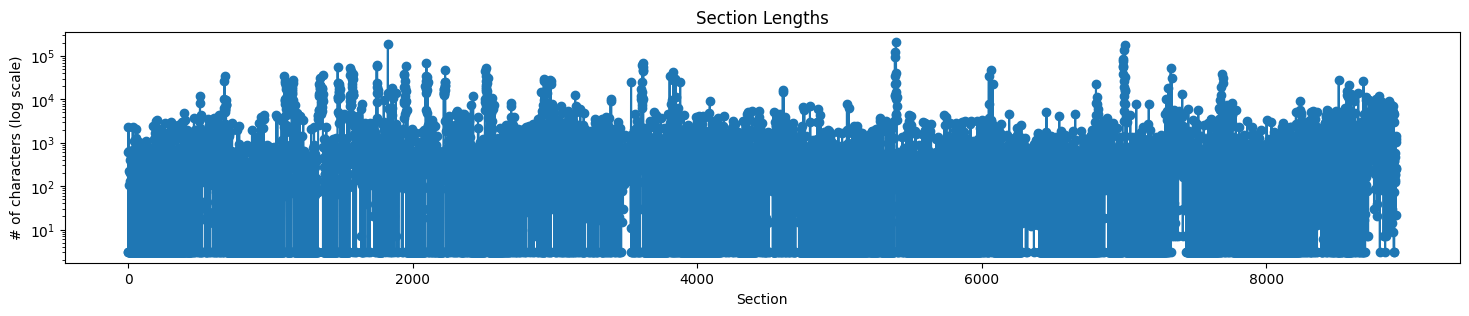

In [17]:
# Sections lengths
plt.figure(figsize=(18, 3))
plt.semilogy(sections_lengths, marker='o')
plt.xlabel('Section')
plt.ylabel('# of characters (log scale)')
plt.title('Section Lengths')
plt.show()

### Chunks

Some of these sections are very large, let's apply some chunking to improve this so that we can use these sections as context later.

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [18]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=600,
    chunk_overlap=50,
    length_function=len,
)

In [19]:
chunks = text_splitter.create_documents(
    texts=[section["text"] for section in sections], 
    metadatas=[{"source": section["source"]} for section in sections]
)

In [20]:
print (f"{len(chunks)} chunks\n")
pprint (chunks[0].page_content)  # a few tokens
print (f"\nmetadata:\n{chunks[0].metadata}")

28803 chunks

('ray.tune.search.optuna.OptunaSearch.mode#\n'
 '\n'
 '\n'
 'property OptunaSearch.mode: str#\n'
 'Specifies if minimizing or maximizing the metric.')

metadata:
{'source': 'https://docs.ray.io/en/master/tune/api/doc/ray.tune.search.optuna.OptunaSearch.mode.html#ray-tune-search-optuna-optunasearch-mode'}


In [21]:
# Ray dataset
chunks_ds = ray.data.from_items([{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks])
chunks_ds.show(1)

2023-08-30 10:44:26,920	INFO dataset.py:2357 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.


{'text': 'ray.tune.search.optuna.OptunaSearch.mode#\n\n\nproperty OptunaSearch.mode: str#\nSpecifies if minimizing or maximizing the metric.', 'source': 'https://docs.ray.io/en/master/tune/api/doc/ray.tune.search.optuna.OptunaSearch.mode.html#ray-tune-search-optuna-optunasearch-mode'}


## Embed data

In [22]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

In [23]:
class EmbedChunks:
    def __init__(self, model_name):
        model_kwargs = {"device": "cuda"}
        encode_kwargs = {"device": "cuda", "batch_size": 100}
        if model_name == "text-embedding-ada-002":
            self.embedding_model = OpenAIEmbeddings(
                model=model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs,
                openai_api_base=os.environ["OPENAI_API_BASE"],
                openai_api_key=os.environ["OPENAI_API_KEY"])
        else:
            self.embedding_model = HuggingFaceEmbeddings(
                model_name=model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs)
    
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

In [24]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=1))

In [29]:
# Sample
sample = embedded_chunks.take(5)
print ("embedding size:", len(sample[0]["embeddings"]))
pprint(sample[0]["text"])

2023-08-30 10:41:48,734	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)]
2023-08-30 10:41:48,735	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-30 10:41:48,735	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-30 10:41:48,748	INFO actor_pool_map_operator.py:110 -- MapBatches(EmbedChunks): Waiting for 1 pool actors to start...


(autoscaler +11m10s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +11m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


KeyboardInterrupt: 

Exception ignored in: <function StreamingExecutor.__del__ at 0x7f387820f8b0>
Traceback (most recent call last):
  File "/home/ray/anaconda3/lib/python3.9/site-packages/ray/data/_internal/execution/streaming_executor.py", line 147, in __del__
    self.shutdown()
  File "/home/ray/anaconda3/lib/python3.9/site-packages/ray/data/_internal/execution/streaming_executor.py", line 160, in shutdown
    self.join(timeout=2.0)
  File "/home/ray/anaconda3/lib/python3.9/threading.py", line 1055, in join
    raise RuntimeError("cannot join thread before it is started")
RuntimeError: cannot join thread before it is started


## Index data

In [25]:
import psycopg
from pgvector.psycopg import register_vector

In [26]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

In [ ]:
%%bash
# Set up pgvector
bash ../setup-pgvector.sh

In [30]:
%%bash
# Drop current vector DB (if any)
psql "$DB_CONNECTION_STRING" -c "DROP TABLE document;"
sudo -u postgres psql -f ../migrations/vector-768.sql

DELETE 0


In [27]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=28),
).count()

2023-08-30 10:44:53,541	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-08-30 10:44:53,542	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-30 10:44:53,543	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-30 10:44:53,556	INFO actor_pool_map_operator.py:110 -- MapBatches(EmbedChunks): Waiting for 1 pool actors to start...
2023-08-30 10:44:59,801	INFO actor_pool_map_operator.py:110 -- MapBatches(StoreResults): Waiting for 28 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-30 10:50:48,486	WARNING actor_pool_map_operator.py:265 -- Your batch size is too large. Currently, your batch size is 128. Your dataset contains 0, and Ray Data tried to parallelize it across 28 actors. To parallelize this fully across all 28 actors, set batch size to not exceed `0 / 28 = 0`.


0

In [28]:
%%bash
# Check number of rows
psql "$DB_CONNECTION_STRING" -c "SELECT count(*) FROM document;" 

 count 
-------
 28803
(1 row)



In [ ]:
%%bash
# Save index
export SQL_DUMP_FP="/efs/shared_storage/goku/sql_dumps/gte-base_300_50.sql"
sudo -u postgres pg_dump -c > $SQL_DUMP_FP  # save

## Retrieval

In [29]:
import json
import numpy as np

In [30]:
embedding_model_name = "thenlper/gte-base"
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
conn = psycopg.connect(os.environ["DB_CONNECTION_STRING"])
register_vector(conn)

In [31]:
# Embed query
query = "What is the default batch size for map_batches?"
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

768

In [32]:
with conn.cursor() as cur:
    cur.execute("SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5", (embedding,))
    rows = cur.fetchall()
    context = [{"text": row[1], "source": row[2]} for row in rows]

In [33]:
for item in context:
    print (item["source"])
    print (item["text"])
    print ()

https://docs.ray.io/en/master/_modules/ray/data/dataset.html
``batch_size`` if ``batch_size`` doesn't evenly divide the block(s) sent
                to a given map task. Default batch_size is 4096 with "default".
            compute: Either "tasks" (default) to use Ray Tasks or an
                :class:`~ray.data.ActorPoolStrategy` to use an autoscaling actor pool.
            batch_format: If ``"default"`` or ``"numpy"``, batches are
                ``Dict[str, numpy.ndarray]``. If ``"pandas"``, batches are
                ``pandas.DataFrame``.
            zero_copy_batch: Whether ``fn`` should be provided zero-copy, read-only

https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size
Configuring batch size#
Increasing batch_size improves the performance of vectorized transformations like
NumPy functions and model inference. However, if your batch size is too large, your
program might run out of memory. If you encounter an out-of-memory error, decrease your
ba

## Generation

In [34]:
import time

In [35]:
import time

def generate_response(
    llm, temperature=0.0, 
    system_content="", assistant_content="", user_content="", 
    max_retries=3, retry_interval=60):
    """Generate response from an LLM."""
    retry_count = 0
    while retry_count < max_retries:
        try:
            response = openai.ChatCompletion.create(
                model=llm,
                temperature=temperature,
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "assistant", "content": assistant_content},
                    {"role": "user", "content": user_content},
                ],
            )
            return response["choices"][-1]["message"]["content"]
        except Exception as e:
            print(e)
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

In [36]:
# Credentials
openai.api_base = os.environ["ANYSCALE_API_BASE"]
openai.api_key = os.environ["ANYSCALE_API_KEY"]

In [38]:
# Generate response
generate_response(
    llm="meta-llama/Llama-2-70b-chat-hf",
    temperature=0.0,
    system_content="Answer the {query} using the provided {context}",
    user_content=f"query: {query}, context: {context}"
)

'The default batch size for map_batches is 4096 when using CPUs, and must be specified explicitly when using GPUs.'

### Query Agent

Let's combine the context retrieval and response generation together into a conventient query agent that we can use to easily generate our responses.

In [39]:
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="meta-llama/Llama-2-70b-chat-hf", 
                 temperature=0.0, max_context_length=4096,
                 system_content="", assistant_content=""):
        
        # Embedding model
        model_kwargs = {"device": "cuda"}
        encode_kwargs = {"device": "cuda", "batch_size": 100}
        if embedding_model_name == "text-embedding-ada-002":
            self.embedding_model = OpenAIEmbeddings(
                model=embedding_model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs,
                openai_api_base=os.environ["OPENAI_API_BASE"],
                openai_api_key=os.environ["OPENAI_API_KEY"])
        else:
            self.embedding_model = HuggingFaceEmbeddings(
                model_name=embedding_model_name,
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs)
            
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - len(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

        # VectorDB connection
        self.conn = psycopg.connect(os.environ["DB_CONNECTION_STRING"])
        register_vector(self.conn)

    def __call__(self, query, num_chunks=6):
        # Get context
        embedding = np.array(self.embedding_model.embed_query(query))
        with self.conn.cursor() as cur:
            cur.execute("SELECT * FROM document ORDER BY embedding <-> %s LIMIT %s", (embedding, num_chunks))
            rows = cur.fetchall()
            context = [{"text": row[1]} for row in rows]
            sources = [row[2] for row in rows]

        # Generate response
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=user_content[: self.context_length],
        )

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
        }
        return result

In [55]:
query = "What is the default batch size for map_batches?"
system_content = "Your job is to answer a question using the additional context provided."
agent = QueryAgent(
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    max_context_length=4096,
    system_content=system_content,
)
result = agent(query=query)
print(json.dumps(result, indent=2))

{
  "question": "What is the default batch size for map_batches?",
  "sources": [
    "https://docs.ray.io/en/master/_modules/ray/data/dataset.html",
    "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size",
    "https://docs.ray.io/en/master/_modules/ray/data/block.html",
    "https://docs.ray.io/en/master/_modules/ray/data/dataset.html",
    "https://docs.ray.io/en/master/_modules/ray/data/dataset.html",
    "https://docs.ray.io/en/master/data/data-internals.html#execution-memory"
  ],
  "answer": "The default batch size for map_batches is 4096 when using CPUs, and must be specified explicitly when using GPUs."
}


## References

We'll start by creating our reference (ground-truth) dataset. We have a list of user queries and the ideal source to answer the query [`datasets/eval-dataset-v1.jsonl`](https://github.com/ray-project/llm-applications/blob/main/datasets/eval-dataset-v1.jsonl). We will our LLM app above to generate reference answer for each query/source pair using `gpt-4`.

In [23]:
import re

In [26]:
with open(Path(ROOT_DIR, "datasets/eval-dataset-v1.jsonl"), "r") as f:
    data = [json.loads(item) for item in list(f)]

In [27]:
# Clean up
for row in data:
    row["source"] = row["source"].replace("https://docs.ray.io/en/latest/", "https://docs.ray.io/en/master/")

In [28]:
data[:5]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'},
 {'question': 'Does Ray support NCCL?',
  'source': 'https://docs.ray.io/en/master/ray-more-libs/ray-collective.html'},
 {'question': 'could you give me an example of using this library for data-parallel training of CNNs on Ray?',
  'source': 'https://docs.ray.io/en/master/ray-air/computer-vision.html#training-vision-models'}]

In [29]:
# Section per document (page) dict
sections_per_doc = {section["source"]: section["text"] for section in sections}
for section in sections:
    page = section["source"]
    if "#" not in page:
        page_sections = [key for key in sections_per_doc.keys() if key.startswith(page)]
        combined_text = "\n".join(sections_per_doc[page_section] for page_section in page_sections)
        sections_per_doc[page] = combined_text

NameError: name 'sections' is not defined

In [38]:
sections_per_doc['https://docs.ray.io/en/master/train/key-concepts.html']

'\n\n\n\nKey Concepts of Ray Train#\nThere are three main concepts in the Ray Train library.\n\nTrainers execute distributed training.\nConfiguration objects are used to configure training.\nCheckpoints are returned as the result of training.\n\n\n\nTrainers#\nTrainers are responsible for executing (distributed) training runs.\nThe output of a Trainer run is a Result that contains\nmetrics from the training run and the latest saved Checkpoint.\nTrainers can also be configured with Datasets and Preprocessors for scalable data ingest and preprocessing.\n\n\nDeep Learning, Tree-Based, and other Trainers#\nThere are three categories of built-in Trainers:\n\n\n\nDeep Learning Trainers\nRay Train supports the following deep learning trainers:\n\nTorchTrainer\nTensorflowTrainer\nHorovodTrainer\nLightningTrainer\n\nFor these trainers, you usually define your own training function that loads the model\nand executes single-worker training steps. Refer to the following guides for more details:\n\

In [39]:
# Checking if any sources are not in our parsed sources
for i, row in enumerate(data):
    if row["source"].startswith("https://docs.ray.io"):
        if row["source"] not in sections_per_doc:
            print(i, row["source"])

In [30]:
# Content for inference
system_content = """
    Your job is {answer} a {query} using the additional {context} provided.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""

In [31]:
def extract_from_response(response):
    # Define regular expressions for extracting values
    answer_pattern = r'"answer"\s*:\s*"([^"]*)"'
    score_pattern = r'"score"\s*:\s*([0-9]+)'
    reasoning_pattern = r'"reasoning"\s*:\s*"([^"]*)"'

    # Extract values using regular expressions
    answer_match = re.search(answer_pattern, response)
    score_match = re.search(score_pattern, response)
    reasoning_match = re.search(reasoning_pattern, response)

    # Convert
    if answer_match and score_match and reasoning_match:
        answer = answer_match.group(1)
        score = float(score_match.group(1))
        reasoning = reasoning_match.group(1)
        return answer, score, reasoning

    return "", "", ""

In [32]:
def get_references(data, sections_per_doc, llm, temperature, max_context_length, system_content, assistant_content):
    results = []
    for row in tqdm(data):
        # Get context
        query = row["question"]
        context = sections_per_doc.get(row["source"], "")

        # Generate response
        context_length = max_context_length - len(system_content + assistant_content)
        user_content = f"The query is {query} and the additional context is {context}"[:context_length]
        response = generate_response(
            llm=llm,
            temperature=temperature,
            system_content=system_content, 
            assistant_content=assistant_content, 
            user_content=user_content)

        # Extract from response
        answer, score, reasoning = extract_from_response(response=response)

        # Store result
        result = ({
                "question": query,
                "source": row["source"],
                "answer": answer,
                "score": score,
                "reasoning": reasoning,
            })
        results.append(result)
    return results

### gpt-4

In [130]:
openai.api_base = os.environ["OPENAI_API_BASE"]
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
llm = "gpt-4"
max_context_length = 8192
results = get_references(
    data=data, sections_per_doc=sections_per_doc, 
    llm=llm, temperature=0.0, max_context_length=max_context_length, 
    system_content=system_content, assistant_content=assistant_content)

If we have some errors in our results, we can rerun those samples again. We could use function calling here but we'll also experiment with generating these reference answers with OSS LLMs (ex. `Llama-2-70b`) which don't have function calling:

```python
error_indices = [i for i, row in enumerate(results) if row["answer"] == "" and row["source"].startswith("https://docs.ray.io")]
for i in tqdm(error_indices):
    row = results[i]
    query = row["question"]
    context = sections_per_doc.get(row["source"], "")
    user_content = f"The question is {query} and the additional context is {context}"[:max_context_length]
    response = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)
    answer, score, reasoning = extract_from_response(response=response)
    result = ({
            "question": query,
            "source": row["source"],
            "answer": answer,
            "score": score,
            "reasoning": reasoning,
        })
    results[i] = result
```

Rerun the above cell until no errors in extraction.

In [142]:
references_fp = Path(ROOT_DIR, "experiments", "references", "gpt-4.json")
references_fp.parent.mkdir(parents=True, exist_ok=True)

In [60]:
# Save to file
with open(references_fp, "w") as fp:
    json.dump(results, fp, indent=4)

In [143]:
# Read from file
with open(references_fp, "r") as fp:
    results = json.load(fp)

In [144]:
# Average score gpt-4 gave itself
print (np.mean([float(result["score"]) for result in results if result["score"]]))

4.527777777777778


In [145]:
# Sample
results[0]

{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
 'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format',
 'answer': "When you're handling Ray Data type conversions and using `map_batches`, you can configure the batch type by specifying `batch_format` in `map_batches()`. You can return either format from your function. If you're dealing with NumPy datasets, your function manipulates the specific numpy dataset. For instance, in the provided example, `increase_brightness` function increases the brightness of an image. Similarly, if you're dealing with pandas DataFrame, you can perform operations like dropping NaN values from the DataFrame using your function. It's vital that the functions are correctly formatted and the intended operation is properly performed in these functions.",
 'score': 5.0,
 'reasoning': 'The provided answer is well-detailed and thorough. It explains why one might be exper

### Llama-2-70b

Let's generate reference responses with `Llama-2-70b` as well:

In [132]:
openai.api_base = os.environ["ANYSCALE_API_BASE"]
openai.api_key = os.environ["ANYSCALE_API_KEY"]

In [ ]:
llm = "meta-llama/Llama-2-70b-chat-hf"
max_context_length = 4096
results = get_references(
    data=data, sections_per_doc=sections_per_doc, 
    llm=llm, temperature=0.0, max_context_length=max_context_length, 
    system_content=system_content, assistant_content=assistant_content)

In [137]:
references_fp = Path(ROOT_DIR, "experiments", "references", "llama-2-70b.json")

In [110]:
# Save to file
with open(references_fp, "w") as fp:
    json.dump(results, fp, indent=4)

In [146]:
# Read from file
with open(references_fp, "r") as fp:
    results = json.load(fp)

In [147]:
# Average score llama-2-70b gave itself
print (np.mean([float(result["score"]) for result in results if result["score"]]))

4.928104575163399


In [129]:
# Sample
results[0]

{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
 'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format',
 'answer': "You can specify the batch format by using the batch_format argument in the map_batches function. For example, to use NumPy ndarrays, you can set batch_format='numpy'. To use pandas DataFrames, you can set batch_format='pandas'.",
 'score': 5.0,
 'reasoning': 'The answer is correct and provides a clear solution to the problem. It also includes examples of how to specify the batch format for both NumPy ndarrays and pandas DataFrames.'}

## Evaluator

Now that we've seen the answers, scores and reasoning for our references dataset from both `gpt-4` and `Llama-2-70b`. We can use these responses to decide on a quality evaluator for our future experiments. This evaluator will be used to score answers for different experiment configuations and so we need to be able to trust their scores, reasoning, etc. After inspecting Llama2 evaluating Llama2's answers, it is definitely not a good evaluator. For most answers the reasoning is not good, and the score is pretty random with lots of 4s. Therefore, our evaluator will be `gpt-4`.

In [41]:
EVALUATOR = "gpt-4"

## Experiments

We're going to start experimenting with the various components in our LLM application such as our evaluator, context, sections, chunking size, number of chunks in our context, embedding models, OSS/closed LLMs and more!

### Utilities

str(Path(ROOT_DIR, "datasets", "eval-dataset-v1.jsonl")Before we get started with our experiments, we're going to define some utility functions that we'll use to easily generate and evaluate responses using the different experiment configurations. We'll also define some functions to help determine our response quality score, retrieval recall score, etc.

In [44]:
import subprocess

In [45]:
# Paths
data_path = str(Path(ROOT_DIR, "datasets", "eval-dataset-v1.jsonl"))
reference_loc = str(Path(ROOT_DIR, "experiments", "references", "gpt-4.json"))

In [42]:
# Mappings
embedding_dimensions = {
    "thenlper/gte-base": 768,
    "BAAI/bge-large-en": 1024,
    "text-embedding-ada-002": 1536
}
max_context_lengths = {
    "gpt-4": 8192,
    "gpt-3.5-turbo": 4096,
    "gpt-3.5-turbo-16k": 16384,
    "meta-llama/Llama-2-7b-chat-hf": 4096,
    "meta-llama/Llama-2-13b-chat-hf": 4096,
    "meta-llama/Llama-2-70b-chat-hf": 4096,
}

In [47]:
def execute_bash(command):
    results = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return results

In [48]:
def create_index(embedding_model_name, chunk_size, chunk_overlap):
    # Drop current Vector DB and prepare for new one
    execute_bash(f'''psql "{os.environ["DB_CONNECTION_STRING"]}" -c "SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE state = 'idle in transaction';"''')
    execute_bash(f'psql "{os.environ["DB_CONNECTION_STRING"]}" -c "DROP TABLE document;"')
    execute_bash(f'sudo -u postgres psql -f ../migrations/vector-{embedding_dimensions[embedding_model_name]}.sql')
    
    SQL_DUMP_FP = Path(EFS_DIR, "sql_dumps", f"{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql")
    if SQL_DUMP_FP.exists():
        # Load from SQL dump
        execute_bash(f'psql "{os.environ["DB_CONNECTION_STRING"]}" -f {SQL_DUMP_FP}')
    else:
        # Create chunks dataset
        text_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", " ", ""],
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
        )
        chunks = text_splitter.create_documents(
            texts=[section["text"] for section in sections], 
            metadatas=[{"source": section["source"]} for section in sections]
        )
        chunks_ds = ray.data.from_items([{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks])

        # Embed chunks
        embedded_chunks = chunks_ds.map_batches(
            EmbedChunks,
            fn_constructor_kwargs={"model_name": embedding_model_name},
            batch_size=100, 
            num_gpus=1,
            compute=ActorPoolStrategy(size=2))
        
        # Index data
        embedded_chunks.map_batches(
            StoreResults,
            batch_size=128,
            num_cpus=1,
            compute=ActorPoolStrategy(size=28),
        ).count()
        
        # Save to SQL dump
        execute_bash(f"sudo -u postgres pg_dump -c > {SQL_DUMP_FP}")

In [43]:
def set_credentials(llm):
    if llm.startswith("gpt"):
        openai.api_base = os.environ["OPENAI_API_BASE"]
        openai.api_key = os.environ["OPENAI_API_KEY"]
    else:
        openai.api_base = os.environ["ANYSCALE_API_BASE"]
        openai.api_key = os.environ["ANYSCALE_API_KEY"]

In [60]:
# Generate responses
def generate_responses(
    experiment_name, data_path, 
    chunk_size, chunk_overlap, num_chunks,
    embedding_model_name, 
    llm, temperature, max_context_length, 
    system_content, assistant_content=""):
    
    # Set credentials
    set_credentials(llm=llm)
    
    # Build index
    # create_index(
    #     embedding_model_name=embedding_model_name,
    #     chunk_size=chunk_size,
    #     chunk_overlap=chunk_overlap,
    # )
    
    # Query agent
    agent = QueryAgent(
        embedding_model_name=embedding_model_name,
        llm=llm,
        temperature=temperature,
        max_context_length=max_context_length,
        system_content=system_content,
        assistant_content=assistant_content,
    )

    # Generate responses
    results = []
    with open(Path(data_path), "r") as f:
        questions = [json.loads(item)["question"] for item in list(f)][300:600]
    for query in tqdm(questions):
        result = agent(query=query, num_chunks=num_chunks)
        results.append(result)

    # Save to file
    responses_fp = Path(ROOT_DIR, "experiments", "responses", f"{experiment_name}.json")
    responses_fp.parent.mkdir(parents=True, exist_ok=True)
    config = {
        "experiment_name": experiment_name,
        "data_path": data_path,
        "chunk_size": chunk_size,
        "chunk_overlap": chunk_overlap,
        "num_chunks": num_chunks,
        "embedding_model_name": embedding_model_name,
        "llm": llm,
        "temperature": temperature,
        "max_context_length": max_context_length,
        "system_content": system_content,
        "assistant_content": assistant_content,
    }
    responses = {
        "config": config,
        "results": results,
    }
    with open(responses_fp, "w") as fp:
        json.dump(responses, fp, indent=4)

In [45]:
def get_retrieval_score(references, generated):
    matches = np.zeros(len(references))
    for i in range(len(references)):
        reference_source = references[i]["source"].split("#")[0]
        if not reference_source:
            matches[i] = 1
            continue
        for source in generated[i]["sources"]:
            # sections don't have to perfectly match
            if reference_source == source.split("#")[0]:
                matches[i] = 1
                continue
    retrieval_score = np.mean(matches)
    return retrieval_score

In [61]:
def evaluate_responses(
    experiment_name, reference_loc, response_loc,
    evaluator, temperature, max_context_length,
    system_content, assistant_content=""):
    
    # Set credentials
    set_credentials(llm=evaluator)
    
    # Load answers
    with open(Path(reference_loc), "r") as f:
        references = [item for item in json.load(f)]
    with open(Path(response_loc), "r") as f:
        generated = [item for item in json.load(f)["results"]]
    assert len(references) == len(generated)

    # Quality score
    results = []
    context_length = max_context_length - len(system_content + assistant_content)
    for ref, gen in tqdm(zip(references, generated), total=len(references)):
        assert ref["question"] == gen["question"]
        user_content = str(
            {
                "question": gen["question"],
                "generated_answer": gen["answer"],
                "reference_answer": ref["answer"],
            }
        )[:context_length]

        # Generate response
        response = generate_response(
            llm=evaluator,
            temperature=temperature,
            system_content=system_content,
            assistant_content=assistant_content,
            user_content=user_content,
        )

        # Extract from response
        score, reasoning = response.split("\n", 1)

        # Store result
        result = {
            "question": gen["question"],
            "generated_answer": gen["answer"],
            "reference_answer": ref["answer"],
            "score": float(score),
            "reasoning": reasoning.lstrip("\n"),
            "sources": gen["sources"],
        }
        results.append(result)

    # Save to file
    evaluator_name = evaluator.split("/")[-1].lower()
    evaluation_fp = Path(ROOT_DIR, "experiments", "evaluations", f"{experiment_name}_{evaluator_name}.json")
    evaluation_fp.parent.mkdir(parents=True, exist_ok=True)
    config = {
        "experiment_name": experiment_name,
        "reference_loc": reference_loc,
        "response_loc": response_loc,
        "evaluator": evaluator,
        "temperature": temperature,
        "max_context_length": max_context_length,
        "system_content": system_content,
        "assistant_content": assistant_content,
    }
    evaluation = {
        "config": config,
        # "retrieval_score": get_retrieval_score(references, generated),
        "quality_score": np.mean([item["score"] for item in results if (item["score"] and item["reference_answer"])]),
        "results": results,
    }
    with open(evaluation_fp, "w") as fp:
        json.dump(evaluation, fp, indent=4)

In [62]:
def run_experiment(
    experiment_name, data_path,
    chunk_size, chunk_overlap, num_chunks,
    embedding_model_name, llm,
    reference_loc, evaluator):
    """Generate responses and evaluate them."""
    
    # Generate responses
    generate_responses(
        experiment_name=experiment_name, 
        data_path=data_path, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name, 
        llm=llm, 
        temperature=0.0, 
        max_context_length=max_context_lengths[llm], 
        system_content="Answer the {query} using the additional {context} provided.")

    '''
    # Evaluate responses
    evaluation_system_content = """
        Your job is to rate the quality of our generated answer {generated_answer}
        given a query {query} and a reference answer {reference_answer}.
        Your score has to be between 1 and 5.
        You must return your response in a line with only the score.
        Do not return answers in any other format.
        On a separate line provide your reasoning for the score as well.
        """
    evaluate_responses(
        experiment_name=experiment_name,
        reference_loc=reference_loc, 
        response_loc=str(Path(ROOT_DIR, "experiments", "responses", f"{experiment_name}.json")),
        evaluator=evaluator, 
        temperature=0.0, 
        max_context_length=max_context_lengths[evaluator],
        system_content=evaluation_system_content)
    '''

In [48]:
def print_experiment(experiment_name, evaluator="gpt-4"):
    eval_fp = Path(ROOT_DIR, "experiments", "evaluations", f"{experiment_name}_{evaluator}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    print (experiment_name)
    print ("  retrieval score:", d["retrieval_score"])
    print ("  quality score:", d["quality_score"])
    print ()

In [9]:
load_dotenv(override=True)

True

In [63]:
import json

reference_loc = "" # str(Path(ROOT_DIR, "experiments", "references", "gpt-4.json"))
data_path = str(Path(ROOT_DIR, "datasets", "full-questions.jsonl"))
experiment_name = "llama-2-70b-full-questions-0300"
# experiment_name = "gpt-4-full-questions-0300"
run_experiment(
    experiment_name=experiment_name, 
    data_path=data_path,
    chunk_size=600, 
    chunk_overlap=50, 
    num_chunks=6,
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    # llm="gpt-4",
    reference_loc=reference_loc,
    evaluator="gpt-4")

  0%|          | 1/300 [00:34<2:53:23, 34.79s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


  1%|          | 2/300 [12:23<35:40:46, 431.03s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


  2%|▏         | 5/300 [22:11<16:25:57, 200.53s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


  3%|▎         | 8/300 [27:16<9:06:59, 112.39s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 10%|▉         | 29/300 [36:50<1:13:31, 16.28s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 10%|█         | 30/300 [40:24<5:39:41, 75.49s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 16%|█▌        | 48/300 [50:32<1:08:18, 16.26s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 17%|█▋        | 52/300 [55:06<2:43:06, 39.46s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 20%|██        | 61/300 [1:03:30<2:43:17, 40.99s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 24%|██▎       | 71/300 [1:18:11<2:58:37, 46.80s/it]  

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693425443.5089312,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 24%|██▍       | 72/300 [1:20:01<4:09:33, 65.67s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 24%|██▍       | 73/300 [1:29:33<13:43:33, 217.68s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 25%|██▌       | 76/300 [1:34:25<7:30:44, 120.74s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 26%|██▌       | 77/300 [1:38:00<9:13:53, 149.03s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 26%|██▌       | 78/300 [1:41:22<10:10:17, 164.94s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 26%|██▋       | 79/300 [1:44:57<11:03:01, 180.01s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 27%|██▋       | 80/300 [1:48:33<11:39:12, 190.70s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 30%|███       | 90/300 [1:58:11<1:43:32, 29.58s/it]  

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 31%|███       | 92/300 [2:01:37<3:23:14, 58.63s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 31%|███▏      | 94/300 [2:05:21<4:28:24, 78.18s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 34%|███▎      | 101/300 [2:12:15<2:30:53, 45.50s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 36%|███▌      | 107/300 [2:18:00<2:12:19, 41.13s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 37%|███▋      | 110/300 [2:22:18<3:02:13, 57.54s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 37%|███▋      | 111/300 [2:25:51<5:28:25, 104.26s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 37%|███▋      | 112/300 [2:29:06<6:51:38, 131.38s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 40%|████      | 120/300 [2:35:59<1:56:29, 38.83s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 40%|████      | 121/300 [2:39:58<4:55:06, 98.92s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 41%|████      | 122/300 [2:45:42<8:31:59, 172.58s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 42%|████▏     | 127/300 [2:54:03<4:18:16, 89.58s/it] 

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693431195.9725204,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 44%|████▍     | 132/300 [3:02:27<3:34:48, 76.72s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 47%|████▋     | 141/300 [3:09:44<1:17:15, 29.15s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 50%|████▉     | 149/300 [3:18:52<1:52:26, 44.68s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 52%|█████▏    | 157/300 [3:26:38<1:26:04, 36.11s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 53%|█████▎    | 159/300 [3:38:58<6:53:05, 175.78s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 54%|█████▎    | 161/300 [3:42:54<5:18:44, 137.58s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 54%|█████▍    | 162/300 [3:46:33<6:12:05, 161.78s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 55%|█████▍    | 164/300 [3:50:46<5:08:55, 136.29s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 56%|█████▌    | 168/300 [3:58:34<3:12:48, 87.64s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 56%|█████▋    | 169/300 [4:02:04<4:31:24, 124.31s/it]

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693435276.6888885,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 57%|█████▋    | 171/300 [4:03:57<3:07:52, 87.39s/it] 

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693435389.9062974,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 57%|█████▋    | 172/300 [4:08:33<5:06:44, 143.79s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 62%|██████▏   | 187/300 [4:25:06<57:04, 30.31s/it]   

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 67%|██████▋   | 200/300 [4:39:32<57:58, 34.78s/it]   

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693437524.956157,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":n

 69%|██████▉   | 207/300 [4:43:16<42:26, 27.38s/it]  

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 72%|███████▏  | 215/300 [4:53:21<56:08, 39.63s/it]   

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 73%|███████▎  | 219/300 [5:02:44<1:50:20, 81.73s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 73%|███████▎  | 220/300 [5:06:23<2:44:03, 123.04s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 75%|███████▍  | 224/300 [5:14:14<1:48:14, 85.45s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 77%|███████▋  | 230/300 [5:21:36<1:21:00, 69.43s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 79%|███████▊  | 236/300 [5:28:39<58:19, 54.69s/it]   

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 79%|███████▉  | 238/300 [5:32:52<1:24:03, 81.35s/it] 

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693440724.2356703,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 81%|████████▏ | 244/300 [5:38:04<53:25, 57.24s/it]  

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 84%|████████▍ | 252/300 [5:48:17<43:05, 53.87s/it]   

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 87%|████████▋ | 260/300 [5:57:27<33:59, 50.99s/it]   

Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693442199.9479775,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"Unknown","param":{}},"generation_time_per_token":null,"generation_time_per_token_batch":

 89%|████████▉ | 268/300 [6:03:38<17:58, 33.71s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 90%|████████▉ | 269/300 [6:11:03<1:21:02, 156.84s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 92%|█████████▏| 276/300 [6:19:31<26:20, 65.86s/it]   

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 92%|█████████▏| 277/300 [6:23:18<43:45, 114.15s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 95%|█████████▌| 286/300 [6:32:52<09:12, 39.46s/it] 

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 97%|█████████▋| 291/300 [6:41:15<12:35, 83.94s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 98%|█████████▊| 294/300 [6:48:09<10:14, 102.37s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)
Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.

aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504 {"generated_text":null,"num_input_tokens":null,"num_input_tokens_batch":null,"num_generated_tokens":null,"num_generated_tokens_batch":null,"preprocessing_time":null,"generation_time":null,"timestamp":1693445431.9544542,"finish_reason":null,"error":{"message":"Your request has exceeded the timeout of 3 minutes. This may be caused by excessive traffic against Anyscale EndpointsPlease either use streaming to hold a longer connection, or update your prompt to shorten the response time.","internal_message":"aviary.backend.server.openai_compat.openai_exception.OpenAIHTTPException: 504","code":504,"type":"U

 98%|█████████▊| 295/300 [6:53:01<13:16, 159.39s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


 99%|█████████▊| 296/300 [6:57:25<12:43, 190.77s/it]

Invalid response object from API: 'Internal Server Error' (HTTP response code was 500)


100%|██████████| 300/300 [7:02:52<00:00, 84.57s/it] 


### Context

We're first going to test if the additonal context we provide is helpful at all. This is to validate that the RAG system is indeed worth the effort.

#### Without context

In [ ]:
num_chunks = 0
experiment_name = "without-context"
run_experiment(
    experiment_name=experiment_name, 
    data_path=data_path,
    chunk_size=100, 
    chunk_overlap=50, 
    num_chunks=num_chunks,
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    reference_loc=reference_loc,
    evaluator=EVALUATOR)

In [44]:
print_experiment(experiment_name=experiment_name)

without-context
  retrieval score: 0.0
  quality score: 2.631284916201117



#### With context

In [ ]:
num_chunks = 5
experiment_name = "with-context"
run_experiment(
    experiment_name=experiment_name, 
    data_path=data_path,
    chunk_size=300, 
    chunk_overlap=50, 
    num_chunks=num_chunks,
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    reference_loc=reference_loc,
    evaluator=EVALUATOR)

In [ ]:
print_experiment(experiment_name=experiment_name)

with-context
  retrieval score: 0.4301675977653631
  quality score: 3.2458100558659218



As we can see, **using context (RAG)** does indeed help in the quality of our answers!

### Sections

#### Without sections

In [55]:
from langchain.document_loaders import ReadTheDocsLoader

In [ ]:
# Load data
loader = ReadTheDocsLoader(f"{EFS_DIR}/docs.ray.io/en/master/", encoding="utf-8", errors="ignore")
docs = loader.load()
for doc in docs:  # clean
    doc.metadata["source"] = doc.metadata["source"].replace(str(EFS_DIR)+"/", "https://")

In [187]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len,
)

In [188]:
# Chunks
chunks = text_splitter.create_documents(
    texts=[doc.page_content for doc in docs], 
    metadatas=[doc.metadata for doc in docs]
)

In [189]:
# Ray dataset
chunks_ds = ray.data.from_items([{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks])
chunks_ds.show(1)

{'text': 'Environments#\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\nTip\nNot all environments work with all algorithms. Check out the algorithm overview for more information.\nConfiguring Environments#', 'source': '/efs/shared_storage/goku/docs.ray.io/en/master/rllib-env.html'}


In [190]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=2))

In [191]:
%%bash
# Drop current vector DB (if any)
psql "$DB_CONNECTION_STRING" -c "DROP TABLE document;"
sudo -u postgres psql -f ../migrations/vector-768.sql

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DROP TABLE
CREATE TABLE


In [192]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=28),
).count()

2023-08-24 16:44:15,944	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-08-24 16:44:15,945	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-24 16:44:15,946	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-24 16:44:15,972	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedChunks): Waiting for 2 pool actors to start...
2023-08-24 16:44:37,256	INFO actor_pool_map_operator.py:117 -- MapBatches(StoreResults): Waiting for 28 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-24 16:51:19,313	WARNING actor_pool_map_operator.py:267 -- To ensure full parallelization across an actor pool of size 28, the specified batch size should be at most 0. Your configured batch size for this operator was 128.


0

In [193]:
%%bash
# Check number of rows
psql "$DB_CONNECTION_STRING" -c "SELECT count(*) FROM document;" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 count 
-------
 49220
(1 row)



In [194]:
%%bash
# Save index
export SQL_DUMP_FP="/efs/shared_storage/goku/sql_dumps/without-sections.sql"
sudo -u postgres pg_dump -c > $SQL_DUMP_FP  # save

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
experiment_name = "without-sections"
run_experiment(
    experiment_name=experiment_name, 
    data_path=data_path,
    chunk_size=300, 
    chunk_overlap=50, 
    num_chunks=5,
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    reference_loc=reference_loc,
    evaluator=EVALUATOR)

In [64]:
print_experiment(experiment_name=experiment_name)

without-sections
  retrieval score: 0.0
  quality score: 3.2849162011173183



#### With sections

In [206]:
%%bash
# Drop current vector DB (if any)
psql "$DB_CONNECTION_STRING" -c "DROP TABLE document;"
sudo -u postgres psql -f ../migrations/vector-768.sql

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DROP TABLE
CREATE TABLE


In [ ]:
%%bash
# Switch VectorDB
export SQL_DUMP_FP="/efs/shared_storage/goku/sql_dumps/with-sections.sql"
psql "$DB_CONNECTION_STRING" -f $SQL_DUMP_FP # load

In [48]:
%%bash
# Check number of rows
psql "$DB_CONNECTION_STRING" -c "SELECT count(*) FROM document;" 

 count 
-------
 57835
(1 row)



In [ ]:
experiment_name="with-sections"
run_experiment(
    experiment_name=experiment_name, 
    data_path=data_path,
    chunk_size=300, 
    chunk_overlap=50, 
    num_chunks=5,
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-70b-chat-hf",
    reference_loc=reference_loc,
    evaluator=EVALUATOR)

In [65]:
print_experiment(experiment_name=experiment_name)

with-sections
  retrieval score: 0.4301675977653631
  quality score: 3.2541899441340782



Looks like isolating sections wasn't really helpful but it doesn't hurt either. We could test with different models (ex. `gpt-3.5-turbo`) to further validate this claim.

### Chunk size

In [63]:
chunk_sizes = [100, 300, 600, 900]

In [ ]:
for chunk_size in chunk_sizes:
    experiment_name = f"chunk-size-{chunk_size}"
    run_experiment(
        experiment_name=experiment_name, 
        data_path=data_path,
        chunk_size=chunk_size, 
        chunk_overlap=50, 
        num_chunks=5,
        embedding_model_name="thenlper/gte-base",
        llm="meta-llama/Llama-2-70b-chat-hf",
        reference_loc=reference_loc,
        evaluator=EVALUATOR)

In [64]:
for chunk_size in chunk_sizes:
    experiment_name = f"chunk-size-{chunk_size}"
    print_experiment(experiment_name=experiment_name)

chunk-size-100
  retrieval score: 0.39106145251396646
  quality score: 2.877094972067039

chunk-size-300
  retrieval score: 0.4301675977653631
  quality score: 3.2653631284916202

chunk-size-600
  retrieval score: 0.547486033519553
  quality score: 3.5335195530726256

chunk-size-900
  retrieval score: 0.547486033519553
  quality score: 3.4860335195530725



Seem that a larger chunk size does help but it tapers off around the 600 characters mark (too much context might be too noisy).

**Note**: If we were to use larger chunk sizes (ours is based on characters), keep in mind that [most](https://huggingface.co/spaces/mteb/leaderboard) open source embedding models have a maximum sequence length of 512 sub-word tokens. This means that if our chunk contains more than 512 sub-word tokens, the embedding wouldn't account for it anyway (unless we finetune our embedding model to have longer sequence lengths).

In [56]:
CHUNK_SIZE = 600
CHUNK_OVERLAP = 50

### Number of chunks

**Note**: Keep in mind that the `chunk_size` you chose multiplied by the `num_chunks` below fits inside the LLM's context length. We're experimenting with the chunk size and number of chunks as if they were indepdent variables but they area heavily related. Especially since all of our LLMs have a finite maximum context length. So ideally, we would tune for a combination if `chunk_size` * `num_chunks`.

In [ ]:
num_chunks_list = [1, 3, 5, 6]

In [ ]:
for num_chunks in num_chunks_list:
    experiment_name = f"num-chunks-{num_chunks}"
    run_experiment(
        experiment_name=experiment_name, 
        data_path=data_path,
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=num_chunks,
        embedding_model_name="thenlper/gte-base",
        llm="meta-llama/Llama-2-70b-chat-hf",
        reference_loc=reference_loc,
        evaluator=EVALUATOR)

In [70]:
for num_chunks in num_chunks_list:
    experiment_name=f"num-chunks-{num_chunks}"
    print_experiment(experiment_name=experiment_name)

num-chunks-1
  retrieval score: 0.2737430167597765
  quality score: 3.2458100558659218

num-chunks-3
  retrieval score: 0.48044692737430167
  quality score: 3.363128491620112

num-chunks-5
  retrieval score: 0.547486033519553
  quality score: 3.53072625698324

num-chunks-6
  retrieval score: 0.5977653631284916
  quality score: 3.5810055865921786



Increasing our number of chunks improves our retrieval and quality scores. We had to stop testing at 6 chunks since our `chunk_size` is 600 tokens and `Llama-2-70b`'s maximum context length is 4096 tokens (we also have to account for the system, assistant and user content to our LLM). This is a major reason to invest in extending context size via RoPE scaling (rotary position embeddings), etc. But it also seems that the benefit of increasing the number of chunks is starting to taper off.

In [57]:
NUM_CHUNKS = 6

### Embedding models

So far, we've used [`thenlper/gte-base`](https://huggingface.co/thenlper/gte-base) as our embedding model because it's a relatively small (0.22 GB) and performant option. But now, let's explore other popular options such the current leader on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard), [`BAAI/bge-large-en`](https://huggingface.co/BAAI/bge-large-en) (1.34 GB), and OpenAI's [`text-embedding-ada-002`](https://openai.com/blog/new-and-improved-embedding-model).

In [67]:
embedding_model_names = ["thenlper/gte-base", "BAAI/bge-large-en", "text-embedding-ada-002"]

In [ ]:
for embedding_model_name in embedding_model_names:
    experiment_name = f"{embedding_model_name.split('/')[-1]}"
    run_experiment(
        experiment_name=experiment_name, 
        data_path=data_path,
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=embedding_model_name,
        llm="meta-llama/Llama-2-70b-chat-hf",
        reference_loc=reference_loc,
        evaluator=EVALUATOR)

In [68]:
for embedding_model_name in embedding_model_names:
    experiment_name = f"{embedding_model_name.split('/')[-1]}"
    print_experiment(experiment_name=experiment_name)

gte-base
  retrieval score: 0.5977653631284916
  quality score: 3.589385474860335

bge-large-en
  retrieval score: 0.35195530726256985
  quality score: 3.1145251396648046

text-embedding-ada-002
  retrieval score: 0.5586592178770949
  quality score: 3.4329608938547485



This is an interesting outcome because the #1 (`BAAI/bge-large-en`) on the current leaderboard isn't necessarily the best for our specific task. Using the smaller `thenlper/gte-base` produced the best retrieval and quality scores in our experiments.

In [58]:
EMBEDDING_MODEL_NAME = "thenlper/gte-base"

### OSS vs. closed LLMs

In [89]:
llms = ["gpt-3.5-turbo",
        "gpt-3.5-turbo-16k",
        "gpt-4",
        "meta-llama/Llama-2-7b-chat-hf", 
        "meta-llama/Llama-2-13b-chat-hf", 
        "meta-llama/Llama-2-70b-chat-hf"]

In [ ]:
for llm in llms:
    experiment_name = f"{llm.split('/')[-1].lower()}"
    run_experiment(
        experiment_name=experiment_name, 
        data_path=data_path,
        chunk_size=CHUNK_SIZE, 
        chunk_overlap=CHUNK_OVERLAP, 
        num_chunks=NUM_CHUNKS,
        embedding_model_name=EMBEDDING_MODEL_NAME,
        llm=llm,
        reference_loc=reference_loc,
        evaluator=EVALUATOR)

In [90]:
for llm in llms:
    experiment_name = f"{llm.split('/')[-1].lower()}"
    print_experiment(experiment_name=experiment_name)

gpt-3.5-turbo
  retrieval score: 0.5977653631284916
  quality score: 3.664804469273743

gpt-3.5-turbo-16k
  retrieval score: 0.664804469273743
  quality score: 3.7960893854748603

gpt-4
  retrieval score: 0.5977653631284916
  quality score: 3.9189944134078214

llama-2-7b-chat-hf
  retrieval score: 0.5977653631284916
  quality score: 2.810055865921788

llama-2-13b-chat-hf
  retrieval score: 0.5977653631284916
  quality score: 3.3715083798882683

llama-2-70b-chat-hf
  retrieval score: 0.5977653631284916
  quality score: 3.5139664804469275



**Note**: Some of our LLMs have much larger context lengths, ex. `gpt-4` is 8192 and `gpt-3.5-turbo-16k` is 16384. We could increase the number of chunks that we use for these since we saw that increasing `num_chunks` continued to improve the retrieval and quality scores. However, we will keep this value fixed for now since the performance started to taper off anyway and so we can compare these performances under the exact same configurations.

In [ ]:
LLM = "llama-2-70b-chat-hf"

## Cost comparisons

**Note**: Our `Llama-2` models are priced at $1/M tokens with [Anyscale Endpoints](https://endpoints.anyscale.com/).

In [64]:
# Pricing details
pricing = {
    "gpt-3.5-turbo": {
        "prompt": 2e-6,
        "sampled": 2e-6
    },
    "gpt-4": {
        "prompt": 3e-5,
        "sampled": 6e-5
    },
    "llama-2-7b-chat-hf": {
        "prompt": 1e-6,
        "sampled": 1e-6
    },
    "llama-2-13b-chat-hf": {
        "prompt": 1e-6,
        "sampled": 1e-6
    },
    "llama-2-70b-chat-hf": {
        "prompt": 1e-6,
        "sampled": 1e-6
    }
}

In [84]:
def cost_analysis(llm):
    experiment_name = f"{llm.split('/')[-1].lower()}"
    eval_fp = Path(ROOT_DIR, "experiments", "evaluations", f"{experiment_name}_{EVALUATOR}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    num_samples = len(d["results"])
    prompt_size, sampled_size = 0, 0
    for result in d["results"]:
        prompt_size += len(result["question"]) + (CHUNK_SIZE * NUM_CHUNKS)
        sampled_size += len(result["generated_answer"])
    total_cost = pricing[experiment_name]["prompt"] * prompt_size + pricing[experiment_name]["sampled"] * sampled_size
    avg_cost = total_cost / num_samples
    
    print (llm)
    print (f"  avg prompt size: {int(prompt_size/num_samples)}")
    print (f"  avg sampled size: {int(sampled_size/num_samples)}")
    print (f"  total cost: ${total_cost:.2f}")
    print (f"  avg cost: ${avg_cost:.2f}")
    print ()

In [85]:
for llm in llms:
    cost_analysis(llm=llm)

gpt-3.5-turbo
  avg prompt size: 3667
  avg sampled size: 1117
  total cost: $1.71
  avg cost: $0.01

gpt-4
  avg prompt size: 3667
  avg sampled size: 828
  total cost: $28.59
  avg cost: $0.16

meta-llama/Llama-2-7b-chat-hf
  avg prompt size: 3667
  avg sampled size: 2509
  total cost: $1.11
  avg cost: $0.01

meta-llama/Llama-2-13b-chat-hf
  avg prompt size: 3667
  avg sampled size: 1663
  total cost: $0.95
  avg cost: $0.01

meta-llama/Llama-2-70b-chat-hf
  avg prompt size: 3667
  avg sampled size: 1573
  total cost: $0.94
  avg cost: $0.01



**Note**: OpenAI's GPT models have [rate limits](https://platform.openai.com/docs/guides/rate-limits) to be aware of when we want to use the LLMs at scale for an application.

## Next steps

- routing
- additional data sources
- longer context lengths
- fine-tune embedding model
- fine-tune base LLM (gpt-3.5 and OSS)